In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
import regression_utils 
import pandas as pd
from scipy.stats import wilcoxon
from sklearn.model_selection import KFold

%load_ext autoreload
%autoreload 2

In [2]:
params_dict = {
    0: {'L': 0, 'lambda_z': 0.01, 'J': 3,     'lambda_x': 0.1},
    1: {'L': 0, 'lambda_z': 0.05, 'J': 5,     'lambda_x': 1.0},
    2: {'L': 0, 'lambda_z': 0.05, 'J': 4,     'lambda_x': 1.0},
    3: {'L': 0, 'lambda_z': 0.1,  'J': 3,   'lambda_x': 0.5},
    4: {'L': 0, 'lambda_z': 0.1,  'J': 3,     'lambda_x': 0.5},
    5: {'L': 0, 'lambda_z': 0.05, 'J': 4,     'lambda_x': 1},
    6: {'L': 0, 'lambda_z': 0.05, 'J': 3,     'lambda_x': 1},
    7: {'L': 0, 'lambda_z': 0.01, 'J': 3,     'lambda_x': 5},
    8: {'L': 0, 'lambda_z': 0.01, 'J': 3,   'lambda_x': 0.5},
    9: {'L': 0, 'lambda_z': 0.01, 'J': 2,   'lambda_x': 1},
    10:{'L': 0, 'lambda_z': 0.1,  'J': 0,     'lambda_x': 5},
    11:{'L': 1, 'lambda_z': 0.05, 'J': 3,     'lambda_x': 5},
}

In [3]:
# P only 

# control = 0, perturbed = 1
rows = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for session_num in range(12):
    with open(f'modeling_data//session{session_num}.pkl', "rb") as f:
        obj = pickle.load(f)

    behavior   = obj['behavior']
    train_data = obj['train']

    Y = behavior[:, :, :2]
    velocity = Y[:, 1:, :] - Y[:, :-1, :]

    U = behavior[:, :, 2]          # (trials, T): control=1, perturbed=0
    U_no_distortion = np.zeros_like(U)

    X_flatten = train_data.reshape((-1, train_data.shape[-1]))

    median = np.median(X_flatten, axis=1, keepdims=True)
    mad    = np.median(np.abs(X_flatten - median), axis=1, keepdims=True)
    thresh = median + 3 * mad

    X_threshold = np.where(X_flatten > thresh, X_flatten, 0.0)
    smoothed_X  = gaussian_filter1d(X_threshold, sigma=1.5, axis=0)

    velocity = np.concatenate([velocity, np.zeros((train_data.shape[0], 1, 2))], axis=1)
    Z = np.concatenate([Y, velocity], axis=-1)     # (trials, T, z_dim)
    X = smoothed_X.reshape(train_data.shape)       # (trials, T, x_dim)

    L = params_dict[session_num]['L']
    J = params_dict[session_num]['J']
    lam_x = params_dict[session_num]['lambda_x']
    lam_z = params_dict[session_num]['lambda_z']

    # ---- Fit ----
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Z)):
        z_train, z_val = Z[train_idx], Z[val_idx]
        x_train, x_val = X[train_idx], X[val_idx]
        u_train, u_val = U[train_idx], U[val_idx]

        res_full = regression_utils.fit_lag_model_ridge_multitrial(
            z_train, x_train, u_train, L=L, J=J,
            lam_x=lam_x, lam_z=lam_z
        )
        m_full, x_pred_full, x_true_full = regression_utils.evaluate_lag_multitrial(
            res_full, z_val, x_val, u_val, L=L, J=J
        )

        # ---- Store row ----
        rows.append({
            "session": session_num,
            "R2_x_full":  m_full["R2_x"],

        })

# ===== Build table =====
df = pd.DataFrame(rows).sort_values("session").reset_index(drop=True)

# Optional: reorder columns nicely
df = df[[
    "session",
    "R2_x_full",
]]

df_session = df.groupby("session").mean(numeric_only=True)

r2_full_session  = df_session["R2_x_full"].values

pd.set_option("display.max_columns", None)
#print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Optional: save to csv
# df.to_csv("model_compare_sessions_Ponly_noK1_full.csv", index=False)



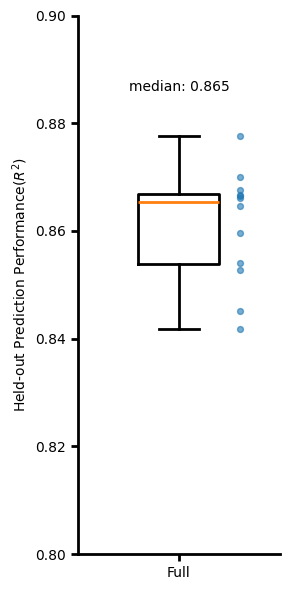

In [4]:

data = [r2_full_session]
labels = ['Full']

fig, ax = plt.subplots(figsize=(3, 6))

# Boxplots
bp = ax.boxplot(
    data,
    positions=[1],
    widths=0.4,
    patch_artist=False,
    showfliers=False,
    medianprops=dict(linewidth=2),
    boxprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=2),
    capprops=dict(linewidth=2),
)

# Overlay individual points with jitter
for i, r2 in enumerate(data, start=1):
    x = np.ones_like(r2)*i + 0.3 #* np.random.randn(len(r2))
    ax.scatter(x, r2, s=18, alpha=0.6, zorder=3)
    ax.text(i, np.median(r2) + 0.02, f"median: {np.median(r2):.3f}",
            ha='center', va='bottom', fontsize=10)

# Axis styling (paper-like)
ax.set_xlim(0.5, 1.5)
ax.set_ylim(0.8, 0.9)
ax.set_xticks([1])
ax.set_xticklabels(labels)
ax.set_ylabel(r'Held-out Prediction Performance($ R^2$)')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(2)

ax.tick_params(width=2, length=5)
#plt.savefig(f'paper_figures_all_sessions/full_model_performance.pdf')

plt.tight_layout()
plt.show()


In [5]:
def R2_vs_baseline(y_true, y_pred, y_base):
    """
    R^2 where the null model is y_base (here: P_only prediction).
    y_true, y_pred, y_base: shape (N, D)
    Returns scalar (global across all dims).
    """
    sse_model = np.sum((y_true - y_pred)**2)
    sse_base  = np.sum((y_true - y_base)**2)
    if sse_base <= 1e-12:
        return np.nan
    return 1.0 - sse_model / sse_base



rows_baseline = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)

for session_num in range(12):
    with open(f'modeling_data/session{session_num}.pkl', "rb") as f:
        obj = pickle.load(f)

    behavior   = obj['behavior']
    train_data = obj['train']

    Y = behavior[:, :, :2]
    velocity = Y[:, 1:, :] - Y[:, :-1, :]

    U = behavior[:, :, 2]
    U_no_distortion = np.zeros_like(U)

    X_flatten = train_data.reshape((-1, train_data.shape[-1]))
    median = np.median(X_flatten, axis=1, keepdims=True)
    mad    = np.median(np.abs(X_flatten - median), axis=1, keepdims=True)
    thresh = median + 3 * mad

    X_threshold = np.where(X_flatten > thresh, X_flatten, 0.0)
    smoothed_X  = gaussian_filter1d(X_threshold, sigma=1.5, axis=0)

    velocity = np.concatenate([velocity, np.zeros((train_data.shape[0], 1, 2))], axis=1)
    Z = np.concatenate([Y, velocity], axis=-1)
    X = smoothed_X.reshape(train_data.shape)

    L = params_dict[session_num]['L']
    J = params_dict[session_num]['J']
    lam_x = params_dict[session_num]['lambda_x']
    lam_z = params_dict[session_num]['lambda_z']

    n_trials = X.shape[0]

    for fold, (tr_idx, te_idx) in enumerate(kf.split(np.arange(n_trials))):
        Z_tr, X_tr, U_tr = Z[tr_idx], X[tr_idx], U[tr_idx]
        Z_te, X_te, U_te = Z[te_idx], X[te_idx], U[te_idx]

        U0_tr = U_no_distortion[tr_idx]
        U0_te = U_no_distortion[te_idx]

        # ---- Fit on TRAIN ----
        res_noK1 = regression_utils.fit_lag_model_ridge_multitrial_noK1(
            Z_tr, X_tr, U0_tr, L=L, J=J, lam_x=lam_x, lam_z=lam_z
        )
        res_full = regression_utils.fit_lag_model_ridge_multitrial(
            Z_tr, X_tr, U_tr, L=L, J=J, lam_x=lam_x, lam_z=lam_z
        )
        res_Ponly = regression_utils.fit_lag_model_ridge_multitrial_Ponly(
            Z_tr, X_tr, U0_tr, L=L, J=J, lam_x=lam_x, lam_z=lam_z
        )

        # ---- Evaluate on TEST ----
        _, x_pred_noK1,  _ = regression_utils.evaluate_lag_multitrial_noK1(
            res_noK1, Z_te, X_te, U0_te, L=L, J=J
        )
        _, x_pred_full,  _ = regression_utils.evaluate_lag_multitrial(
            res_full, Z_te, X_te, U_te, L=L, J=J
        )
        _, x_pred_Ponly, x_true_Ponly = regression_utils.evaluate_lag_multitrial_Ponly(
            res_Ponly, Z_te, X_te, U0_te, L=L, J=J
        )

        # ---- Flatten (global across neurons & time) ----
        num_neurons = x_true_Ponly.shape[-1]
        y_true_2d = x_true_Ponly.reshape(-1, num_neurons)
        y_base_2d = x_pred_Ponly.reshape(-1, num_neurons)

        # relative R^2 vs baseline (your metric)
        r2_full_vs_Ponly = R2_vs_baseline(
            y_true_2d, x_pred_full.reshape(-1, num_neurons), y_base_2d
        )
        r2_K0_vs_Ponly = R2_vs_baseline(
            y_true_2d, x_pred_noK1.reshape(-1, num_neurons), y_base_2d
        )

        rows_baseline.append({
            "session": session_num,
            "fold": fold,
            "R2_full_vs_Ponly": r2_full_vs_Ponly,
            "R2_K0only_vs_Ponly": r2_K0_vs_Ponly,
        })

df = pd.DataFrame(rows_baseline)
#print(df.round(4))

df_session = df.groupby("session").mean(numeric_only=True)
#print("\nPer-session mean across folds:")
#print(df_session.round(4))


In [6]:
baseline_R2_K0_only = df_session['R2_K0only_vs_Ponly'].to_numpy()
baseline_R2_full = df_session['R2_full_vs_Ponly'].to_numpy()


# one-sided: test full > K9
stat, p = wilcoxon(baseline_R2_full, baseline_R2_K0_only, alternative="greater")

print(stat, p)

d = baseline_R2_full - baseline_R2_K0_only

# paired bootstrap CI
def bootstrap_ci_paired(d, n_boot=10000, alpha=0.05):
    rng = np.random.default_rng(0)
    stats = [np.mean(rng.choice(d, size=len(d), replace=True))
             for _ in range(n_boot)]
    return np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])

ci_low, ci_high = bootstrap_ci_paired(d)
print(np.median(d), (ci_low, ci_high))


74.0 0.001708984375
0.004657843850641964 (0.002350189538197382, 0.006369063058942305)


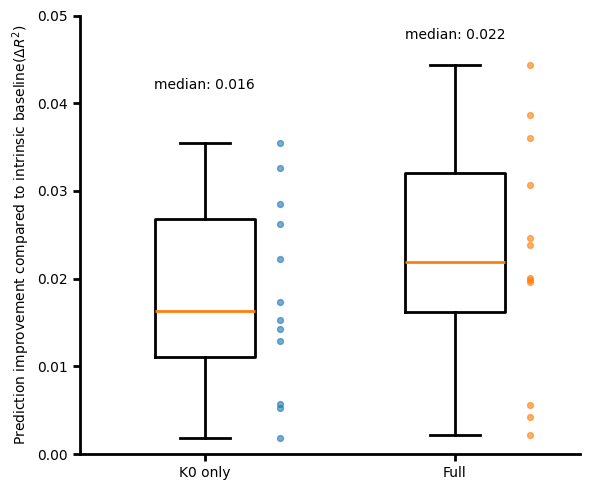

In [7]:

data = [baseline_R2_K0_only, baseline_R2_full]
labels = ['K0 only', 'Full']

fig, ax = plt.subplots(figsize=(6, 5))

# Boxplots
bp = ax.boxplot(
    data,
    positions=[1, 2],
    widths=0.4,
    patch_artist=False,
    showfliers=False,
    medianprops=dict(linewidth=2),
    boxprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=2),
    capprops=dict(linewidth=2),
)

# Overlay individual points with jitter
for i, r2 in enumerate(data, start=1):
    x = np.ones_like(r2)*i + 0.3 #* np.random.randn(len(r2))
    ax.scatter(x, r2, s=18, alpha=0.6, zorder=3)
    ax.text(i, np.median(r2) + 0.025, f"median: {np.median(r2):.3f}",
            ha='center', va='bottom', fontsize=10)

# Axis styling (paper-like)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(0, 0.05)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel(r'Prediction improvement compared to intrinsic baseline($\Delta R^2$)')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(2)

ax.tick_params(width=2, length=5)
#plt.savefig(f'paper_figures_all_sessions/K0_full_comparison_intrinsic_baseline.pdf')

plt.tight_layout()
plt.show()


In [8]:
ctrl_r2_session = []
dev_r2_session = []
for session_num in range(12):
    with open(f'modeling_data/session{session_num}.pkl', "rb") as f:   # "rb" = read, binary
        obj = pickle.load(f)
    #print(f"======session {session_num}")
    behavior = obj['behavior']
    train_data = obj['train']
    test_data = obj['test']

    #print(behavior.shape, train_data.shape)

    Y = behavior[:,:, :2]
    velocity = Y[:, 1:, :] - Y[:, :-1, :]
    U = 1-behavior[:,:, 2]
    X_flatten = train_data.reshape((-1, train_data.shape[-1]))

    median = np.median(X_flatten, axis = 1, keepdims=True)
    mad = np.median(np.abs(X_flatten - median), axis = 1, keepdims=True)

    thresh = median + 3*mad
    X_threshold = np.where(X_flatten > thresh, X_flatten, 0.0)
    smoothed_X = gaussian_filter1d(X_threshold, sigma = 1.5, axis = 0)

    velocity = np.concatenate([velocity, np.zeros((train_data.shape[0], 1 ,2))],axis = 1)
    Z = np.concatenate([Y, velocity],axis = -1)
    U = U
    X = smoothed_X.reshape(train_data.shape)

    deviation_trial_index = np.unique(np.where(behavior[:, :, -1]==1)[0])
    non_deviation_trial_index = sorted(set(range(behavior.shape[0])) - set(deviation_trial_index))

    mean_control = np.mean(X[non_deviation_trial_index], axis=0)
    mean_dev = np.mean(X[deviation_trial_index], axis=0)

    mean_behavior_control = np.mean(Z[non_deviation_trial_index],axis = 0)
    mean_behavior_dev = np.mean(Z[deviation_trial_index],axis = 0)

    pca = PCA(n_components=3)
    mean_data = np.vstack([mean_control, mean_dev])
    mean_proj = pca.fit_transform(mean_data)

    colors = {'ctrl': '#a4aca7', 'pert': '#C13C33', 'passive': '#006d87'}
    trajectories = {'ctrl': mean_proj[:60], 'dev': mean_proj[60:]}
    trajectories = {k: v for k, v in trajectories.items() if v is not None}

    colors = {'ctrl': '#a4aca7', 'pert': '#C13C33'}
    plane_normal_ctrl, r2_ctrl, reg_ctrl, d_ctrl = regression_utils.fit_trk_plane(trajectories['ctrl'])
    rmse_ctrl = regression_utils.compute_rmse(trajectories['ctrl'], reg_ctrl)
    ctrl_r2_session.append(r2_ctrl)

    plane_normal_dev, r2_dev, reg_dev, d_dev = regression_utils.fit_trk_plane(trajectories['dev'])
    dev_r2_session.append(r2_dev)

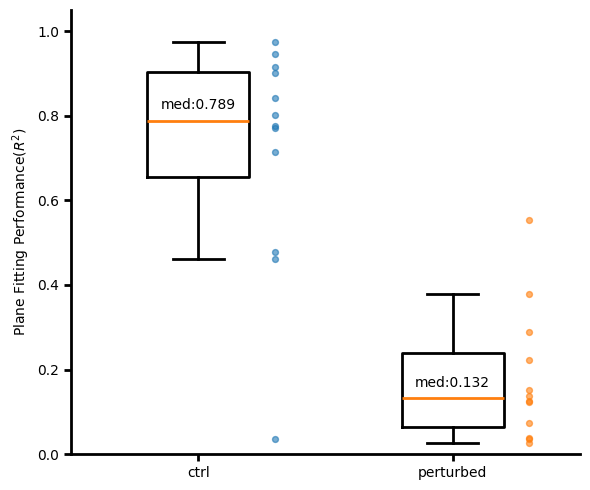

In [9]:

data = [ctrl_r2_session, dev_r2_session]
labels = ['ctrl', 'perturbed']

fig, ax = plt.subplots(figsize=(6, 5))

# Boxplots
bp = ax.boxplot(
    data,
    positions=[1, 2],
    widths=0.4,
    patch_artist=False,
    showfliers=False,
    medianprops=dict(linewidth=2),
    boxprops=dict(linewidth=2),
    whiskerprops=dict(linewidth=2),
    capprops=dict(linewidth=2),
)

# Overlay individual points with jitter
for i, r2 in enumerate(data, start=1):
    x = np.ones_like(r2)*i + 0.3 #* np.random.randn(len(r2))
    ax.scatter(x, r2, s=18, alpha=0.6, zorder=3)
    ax.text(i, np.median(r2) + 0.02, f"med:{np.median(r2):.3f}",
            ha='center', va='bottom', fontsize=10)

# Axis styling (paper-like)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(0, 1.05)
ax.set_xticks([1, 2])
ax.set_xticklabels(labels)
ax.set_ylabel(r'Plane Fitting Performance($ R^2$)')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_linewidth(2)

ax.tick_params(width=2, length=5)
#plt.savefig(f'paper_figures_all_sessions/fit_plane_r2.pdf')

plt.tight_layout()
plt.show()
